# Analysis plan

* Load training data
* Make sure classes are evenly balanced, otherwise throw exception
* Load validation data
* Train model on training data
* Test model on validation data
* Move uncertain images from training and holdout sets to review folder
* Manually review uncertain images
* Adjust images as needed (delete bad images and move misclassified good images to training set)
* Calculate validation metrics for each occupation
* Create more training data if some occupations have bad metrics
* Repeat as needed
* Run final model against holdout data that hasn't been previously examined
* Calculate overall metrics and break out by gender and occupation
* Run final model against unlabeled data
* Save prediction for each image
* Calculate gender representation for each occupation

In [1]:
import datetime
import os
import shutil
from typing import Dict, List, NamedTuple, Union

import PIL
import cv2
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import polars as pl
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from IPython.display import display
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet50_Weights

if not torch.cuda.is_available():
    print("No GPU available, falling back to CPU")

In [198]:
# Helpers

# Functions
def current_time_only(file_safe: bool = False) -> str:
    """
    Returns the current time at second precision without date.

    Parameters:
    file_safe (bool): If True, returns time formatted for file naming (replaces ':' with '_').

    Returns:
    str: Current time formatted as 'HH:MM:SS' or 'DD_HH_MM_SS' if file_safe is True.
    """
    if file_safe:
        return datetime.datetime.now().strftime('%d:%H:%M:%S').replace(":", "_")
    else:
        return datetime.datetime.now().strftime('%H:%M:%S')


def count_files_in_directory(path: Union[str, 'LiteralString']) -> int:
    """
    Counts the number of files in a given directory.

    Parameters:
    path (Union[str, 'LiteralString']): The file path to the directory whose contents are to be counted.

    Raises:
    ValueError: If path is not a directory or does not exist.

    Returns:
    int: The number of files in the specified directory.
    """
    if not os.path.isdir(path):
        raise ValueError(f"{path} is not a directory.")
    return len(os.listdir(path))


def plot_training_progress(train_acc: list,
                           train_loss: list,
                           val_acc: list,
                           validation_loss: list,
                           title="Model results"):
    """
    Plot training-vs-testing accuracy and loss for each epoch.
    
    Parameters:
        train_acc (list): List of training accuracy values from each epoch, must be same length as val_acc
        train_loss (list): List of training loss values from each epoch, must be same length as val_loss
        val_acc (list): List of validation accuracy values from each epoch, must be same length as train_acc
        validation_loss (list): List of validation loss values from each epoch, must be same length as train_loss
        title (str): Plot title
    
    Raises:
        ValueError: If the lengths of accuracy or loss lists don't match each other
    """
    if not (len(train_acc) == len(val_acc) and len(train_loss) == len(validation_loss)) and len(train_acc) > 0 and len(
            train_loss) > 0:
        raise ValueError("Lengths of training and validation lists must match")
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(train_acc,
                label="Training accuracy",
                color=train_color,
                linewidth=3)
    axs[0].plot(val_acc,
                label="Validation accuracy",
                color=val_color,
                linewidth=3)
    axs[0].set_title("Accuracy")
    axs[0].legend()

    axs[1].plot(train_loss,
                label="Training loss",
                color=train_color,
                linewidth=3)
    axs[1].plot(validation_loss,
                label="Validation loss",
                color=val_color,
                linewidth=3)
    axs[1].set_title("Loss")
    axs[1].set(ylim=(0, None))
    axs[1].legend()

    fig.suptitle(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()


def add_occupation(image_data_frame: pl.DataFrame) -> pl.DataFrame:
    """
    Adds an 'occupation' column to the DataFrame by first neutralizing gender-specific terms 
    in the 'file_path' column and then extracting the occupation.

    The function first removes 'female_' or 'male_' from the 'file_path', then assumes that 
    the occupation is embedded in the modified file path string, following a specific pattern 
    (fourth underscore-separated value after removal of gender terms).

    Parameters:
    image_data_frame (pl.DataFrame): A DataFrame with a column named 'file_path'.

    Returns:
    pl.DataFrame: The original DataFrame with an added 'occupation' column, 
                  and 'neutered_file_path' if intermediate results are to be kept.

    Raises:
    ValueError: If the 'file_path' column does not exist in the DataFrame.
    """
    if 'file_path' not in image_data_frame.columns:
        raise ValueError("The DataFrame must contain a 'file_path' column.")

    return image_data_frame.with_columns(
        pl.col("file_path").str.replace(pattern="(female_|male_)", value="")
        .str.extract("(?:[^_]*_){4}([^_]*)_").alias(
            "occupation")
    )


def label_images(csv_file: str, output_file: str):
    """
    Reads images from a specified CSV file and allows the user to label them interactively.

    This function opens each image specified in the CSV file and displays it to the user. 
    The user can then label the image as 'Female', 'Male', or 'Discard' by pressing the corresponding 
    keys ('f', 'm', 'd' or '0', '1', '2'). The function logs the user's decision along with the image 
    path and writes this data to an output file.

    Parameters:
    csv_file (str): Path to the CSV file containing the paths of the images to be labeled.
    output_file (str): Path to the output CSV file where the image paths and labels will be saved.

    Raises:
    ValueError: If a key pressed is not among the specified keys ('f', 'm', 'd', '0', '1', '2').

    Notes:
    The function adds a text overlay to each image before displaying it, which indicates the keys 
    for labeling. If an image cannot be read, it logs the path with the label "ERROR".
    """
    image_labels = []
    image_files = pl.read_csv(csv_file).to_series().to_list()

    for image_path in image_files:
        image = cv2.imread(image_path)
        if image is not None:
            cv2.putText(image, "'F'emale, 'M'ale, 'D'iscard", (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.imshow("Image", image)

            key = cv2.waitKey(0)  # Wait for a key press
            if key == ord('0') or key == ord('f'):
                image_labels.append((image_path, "Female"))
            elif key == ord('1') or key == ord('m'):
                image_labels.append((image_path, "Male"))
            elif key == ord('2') or key == ord('d'):
                image_labels.append((image_path, "Discard"))
            else:
                raise ValueError("Only allowed values are 0, 1, 2, f, m, and d")
            print(f"Key pressed: {chr(key)}")

            cv2.destroyAllWindows()
        else:
            print(f"Could not read image: {image_path}")
            image_labels.append((image_path, "ERROR"))

    with open(output_file, 'w') as f:
        for item in image_labels:
            f.write(f"{item[0]},{item[1]}\n")


def calculate_normalization(custom_normalization: bool) -> Dict[str, List[float]]:
    """
    Calculates the mean and standard deviation of the dataset for normalization.

    Parameters:
    custom_normalization (bool): Determines if custom normalization values are to be calculated.

    Returns:
    Dict[str, List[float]]: A dictionary containing 'mean' and 'std', each a list of three floats.

    Notes:
    Function uses global variables batch_size and data_dir.
    """
    if custom_normalization:
        # Create a dataset without normalization
        unnormalized_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=tensor_transform)
        unnormalized_loader = DataLoader(unnormalized_dataset, batch_size=batch_size, shuffle=True)

        def calculate_mean_std(loader: DataLoader) -> (torch.Tensor, torch.Tensor):
            """
            Calculate the mean and standard deviation of images in a DataLoader.
        
            Parameters:
            loader (DataLoader): The DataLoader containing the dataset.
        
            Returns:
            Tuple[torch.Tensor, torch.Tensor]: Mean and standard deviation tensors.
            """
            mean_accumulator = 0.0
            variance_accumulator = 0.0
            for images, _ in loader:
                batch_samples = images.size(0)
                images = images.view(batch_samples, images.size(1), -1)
                mean_accumulator += images.mean(2).sum(0)
                variance_accumulator += images.var(2).sum(0)

            mean_accumulator /= len(loader.dataset)
            std_deviation = torch.sqrt(variance_accumulator / len(loader.dataset))
            return mean_accumulator, std_deviation

        dataset_mean, dataset_std = calculate_mean_std(unnormalized_loader)
        normalization_dict = {'mean': dataset_mean.tolist(), 'std': dataset_std.tolist()}
        del unnormalized_dataset, unnormalized_loader
        print(f"Custom normalization values: {normalization_dict}")
    else:
        normalization_dict = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
        print("Standard normalization values used")
    return normalization_dict


def display_images_from_dataloader(dataloader: DataLoader, num_images: int = 8):
    """
    Fetches a batch of images from the given DataLoader and displays them to user.
    
    Parameters:
    dataloader (DataLoader): A PyTorch DataLoader object from which to fetch the images.
    num_images (int): The number of images to display from the batch.
    """

    def imshow(img: torch.Tensor):
        """
        Display an image by denormalizing and clipping its values.

        This function takes a PyTorch tensor representing a grid of images, which have been normalized 
        previously, and performs denormalization to convert them back to their original color 
        space. It then clips the image values to be within the range [0, 1] to ensure 
        proper display. The image is displayed using matplotlib.

        Parameters:
        img (torch.Tensor): A PyTorch tensor representing a grid of images.
        """
        img = img.numpy().transpose((1, 2, 0))
        img = normalization_values['std'] * img + normalization_values['mean']  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be between 0 and 1
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()

    num_images = min(batch_size, num_images)
    dataset_images, dataset_labels = next(iter(dataloader))
    images_subset = dataset_images[:num_images]
    imshow(torchvision.utils.make_grid(images_subset))
    print(' '.join(f'{classes[dataset_labels[j]]:5s}' for j in range(num_images)))


def predict_model_resnet(my_dataloader):
    """
    Performs predictions using a ResNet model on a given dataloader.
    
    This function runs the ResNet model in evaluation mode and generates predictions for the input data. 
    It requires the dataloader to have a batch size of exactly 1. The function outputs a dataframe 
    with file paths, actual labels, predicted labels, probabilities of being female, and a flag indicating 
    correct predictions.
    
    Note: The sorting logic in the function is based on the condition of correct predictions and their confidence scores.
    
    Parameters:
    my_dataloader (Dataloader): A PyTorch Dataloader object containing the data to be predicted. 
                                 The dataloader must have a batch size of 1.
    
    Raises:
    ValueError: If the dataloader's batch size is not 1.
    
    Returns:
    Polars.DataFrame: A dataframe containing columns for file paths, labels, predictions, 
                      probabilities, and correct predictions.
    """
    if my_dataloader.batch_size != 1:
        raise ValueError("Predictions dataloader requires batch size of exactly 1")
    model_resnet.eval()
    # TODO: Consider changing label from str to enum per Github issue #16
    prediction_results = pl.DataFrame(schema={"file_path": str, "label": int, "prediction": int, "prob_female": float})
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(my_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            prob_female = torch.nn.functional.softmax(outputs, dim=1)[:, 0].tolist()
            predicted = predicted.tolist()
            labels = labels.tolist()
            file_paths = my_dataloader.dataset.samples[i][0]
            batch_results = pl.DataFrame({"file_path": file_paths,
                                          "label": labels,
                                          "prediction": predicted,
                                          "prob_female": prob_female})
            prediction_results = pl.concat([prediction_results, batch_results], how="vertical_relaxed")
        prediction_results = prediction_results.with_columns(
            (1 * (pl.col("label") == pl.col("prediction"))).alias("correct_prediction")
        )
        # I couldn't figure out the sorting logic so I asked SO
        # https://stackoverflow.com/questions/77700489/how-to-perform-a-conditional-sort-in-polars/77700711
        prediction_results = prediction_results.with_columns(
            abs(pl.col("prob_female") - 0.5).alias("confidence")
        ).sort([
            (good_prediction := pl.col('label').eq(pl.col('prediction'))),
            (good_prediction - 1) * pl.col('confidence'),
            pl.col('confidence')
        ])
        return prediction_results


def move_image(file_path, new_folder) -> None:
    """
    Move image located at file_path to new_folder.
    
    :param file_path: Location of file to be moved.
    :param new_folder: Folder where you want the file to be moved.
    :return: None
    """
    new_path = os.path.join(data_dir, new_folder, os.path.basename(file_path))
    os.makedirs(os.path.dirname(new_path), exist_ok=True)
    shutil.move(file_path, new_path)
    print(f"File {file_path} successfully moved to {new_folder}")
    with open("file_move_history.txt", 'a') as f:
        f.write(f"{file_path}\n")


def move_labeled_images(image_label_dataframe_path: str = "labels.csv"):
    image_label_dataframe = pl.read_csv(image_label_dataframe_path,
                                        has_header=False,
                                        new_columns=["file_path", "gender"],
                                        schema={"file_path": pl.Utf8, "gender": pl.Utf8}).with_columns(
        # Only allow the three valid image labels
        pl.col("gender").cast(pl.Enum(categories=["Female", "Male", "Discard"]))
    )

    for row in image_label_dataframe.iter_rows():
        file_path, label = row
        sub_folder = file_path.replace(data_dir, "", 1).strip(os.sep).split(os.sep)[0].lstrip()
        sub_folder = data_dir + sub_folder
        destination_folder = os.path.join(sub_folder, label)
        current_folder = os.path.dirname(file_path)
        # Check if the current folder is the same as the destination folder
        if current_folder != destination_folder:
            if os.path.isfile(file_path):
                move_image(file_path, destination_folder)
            else:
                print(f"Image not found: {file_path}")
        else:
            print(f"File is already in the correct folder: {file_path}")
            with open("file_move_history.txt", 'a') as f:
                f.write(f"{file_path}\n")


# Classes
class ImbalancedClassesException(ValueError):
    """Exception raised when classes must be perfectly balanced and are not."""


class Colors(NamedTuple):
    train: str
    val: str
    unlabeled: str

In [180]:
# Config variables
colors = Colors(train="#ff130f", val="#7fff0f", unlabeled="#0fefff")
train_color = colors.train
val_color = colors.val
unlabeled_color = colors.unlabeled

data_dir: str = 'H:/Photos/AI/'
batch_size: int = 30
classes: tuple[str, str] = ('Female', 'Male')
use_custom_normalization: bool = True
num_epochs: int = 2

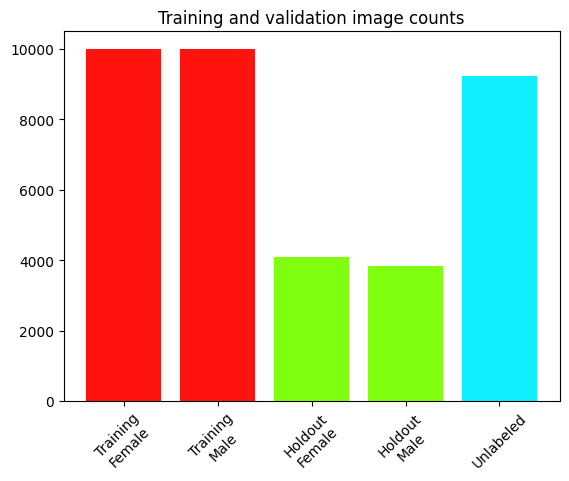

In [181]:
# Count the number of images in each training folder and throw exception if imbalanced
file_counts = {category: {gender: count_files_in_directory(
    os.path.join(data_dir, category, gender))
    for gender in classes}
    for category in ['Labeled', 'Holdout']}
file_counts.update({'Unlabeled': count_files_in_directory(os.path.join(data_dir, "Unlabeled/Unlabeled"))})

fig, ax = plt.subplots()
ax.bar(['Training\nFemale', 'Training\nMale',
        'Holdout\nFemale', 'Holdout\nMale',
        'Unlabeled'],
       [file_counts['Labeled']['Female'],
        file_counts['Labeled']['Male'],
        file_counts['Holdout']['Female'],
        file_counts['Holdout']['Male'],
        file_counts['Unlabeled']],
       color=[train_color, train_color, val_color, val_color, unlabeled_color])
plt.xticks(rotation=45)
plt.title("Training and validation image counts")
plt.show()

if file_counts['Labeled']['Female'] != file_counts['Labeled']['Male']:
    female_count = file_counts['Labeled']['Female']
    male_count = file_counts['Labeled']['Male']
    raise ImbalancedClassesException(
        f'Imbalance detected: {female_count} female images vs {male_count} male images')

In [5]:
tensor_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

normalization_values = calculate_normalization(use_custom_normalization)

Custom normalization values: {'mean': [0.5009773373603821, 0.49618539214134216, 0.4948263168334961], 'std': [0.2933335304260254, 0.2675815522670746, 0.2787638008594513]}


In [6]:
# Load train/test images in Pytorch format
transformations = transforms.Compose([
    transforms.Resize((512, 512)),  # Images are already 512x512, but it's good to be sure
    transforms.ToTensor(),
    transforms.Normalize(mean=normalization_values['mean'], std=normalization_values['std'])
])

train_dataset = ImageFolder(os.path.join(data_dir, 'Labeled'), transform=transformations)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = ImageFolder(os.path.join(data_dir, 'Holdout'), transform=transformations)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

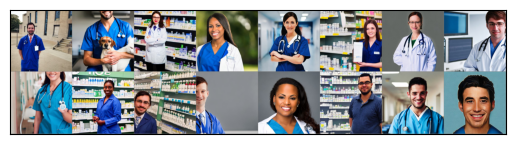

Male  Male  Female Female Female Female Female Male  Female Female Male  Male  Female Male  Male  Male 


In [7]:
display_images_from_dataloader(train_loader, num_images=16)

# ResNet model

In [8]:
# Load a pre-trained ResNet model
model_resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Freeze the layers except the final layer
for param in model_resnet.parameters():
    param.requires_grad = False

# Replace the last fully connected layer for binary classification
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 2)

# Move model_resnet to GPU (if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

In [9]:
resnet_train_epoch_loss = []
resnet_train_epoch_accuracy = []
resnet_validation_epoch_loss = []
resnet_validation_epoch_accuracy = []

# Fine-tune the ResNet model
for epoch in range(num_epochs):
    model_resnet.train()
    print(f"Epoch {epoch + 1} initiated ({current_time_only()})")
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, data in enumerate(train_loader, 0):
        if i % 250 == 0:
            print(f"Training batch {i + 1}/{len(train_loader)} ({current_time_only()})")
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    resnet_train_epoch_loss.append(running_loss / len(train_loader))
    resnet_train_epoch_accuracy.append(correct_train / total_train)

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        print(f"Validation started ({current_time_only()})")
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_resnet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate validation loss and accuracy for the epoch
    epoch_val_loss = val_loss / len(val_loader)
    epoch_val_accuracy = correct / total
    resnet_validation_epoch_loss.append(epoch_val_loss)
    resnet_validation_epoch_accuracy.append(epoch_val_accuracy)

    # Extra fancy console output
    print("\n" + "*" * 50)
    print(f"{'*' * 10} EPOCH {epoch + 1} RESULTS {'*' * 10}".center(50))
    print("*" * 50)
    print(f'\033[94mTrain Loss: {running_loss / len(train_loader):.3f}\033[0m, '
          f'\033[92mValidation Loss: {epoch_val_loss:.3f}\033[0m, '
          f'\033[93mTraining Accuracy: {100 * correct_train / total_train:.2f}%\033[0m, '
          f'\033[91mValidation Accuracy: {100 * epoch_val_accuracy:.2f}%\033[0m')
    print("*" * 50 + "\n")

print(f'Finished Training ({current_time_only()})')

Epoch 1 initiated (11:55:51)
Training batch 1/667 (11:55:51)
Training batch 251/667 (12:03:13)
Training batch 501/667 (12:10:36)
Validation started (12:15:19)

**************************************************
      ********** EPOCH 1 RESULTS **********       
**************************************************
Train Loss: 0.272, Validation Loss: 0.163, Training Accuracy: 89.83%, Validation Accuracy: 94.33%
**************************************************

Epoch 2 initiated (12:23:04)
Training batch 1/667 (12:23:04)
Training batch 251/667 (12:30:40)
Training batch 501/667 (12:38:00)
Validation started (12:42:50)

**************************************************
      ********** EPOCH 2 RESULTS **********       
**************************************************
Train Loss: 0.164, Validation Loss: 0.113, Training Accuracy: 93.83%, Validation Accuracy: 96.11%
**************************************************

Finished Training (12:50:00)


In [13]:
torch.save(model_resnet, "model_resnet_.pt")

In [ ]:
# TODO: Load model from disk

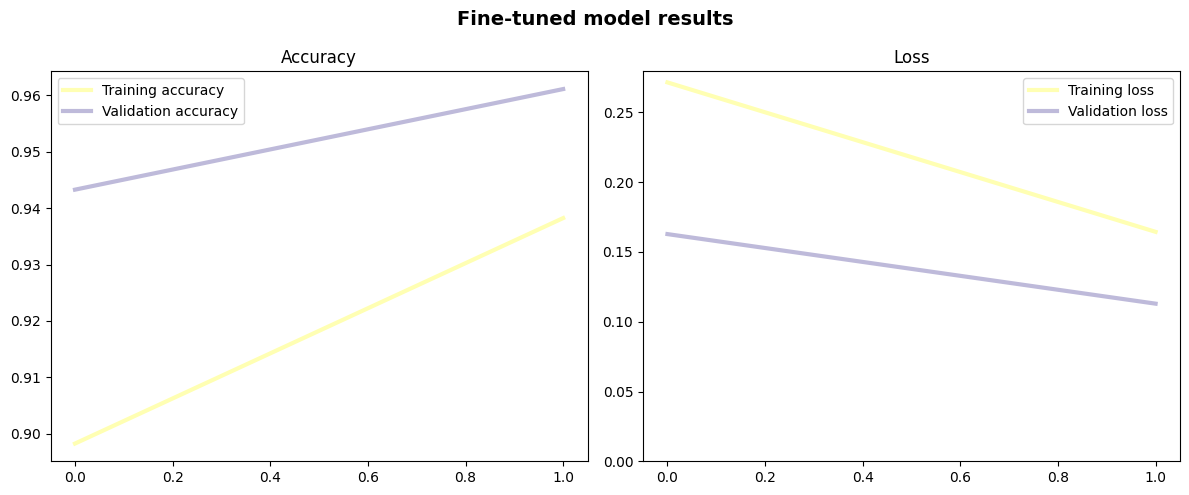

In [16]:
plot_training_progress(train_acc=resnet_train_epoch_accuracy,
                       train_loss=resnet_train_epoch_loss,
                       val_acc=resnet_validation_epoch_accuracy,
                       validation_loss=resnet_validation_epoch_loss,
                       title="Fine-tuned model results")

# Manual image classification

In [204]:
train_exploration_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
train_exploration_results = predict_model_resnet(train_exploration_loader)

KeyboardInterrupt: 

In [ ]:
(train_exploration_results
.filter((pl.col("confidence") < 0.1) | (pl.col("correct_prediction") == 0))
.sort([
    (good_prediction := pl.col('label').eq(pl.col('prediction'))),
    (good_prediction - 1) * pl.col('confidence'),
    pl.col('confidence')
]))

In [17]:
exploration_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
exploration_results = predict_model_resnet(exploration_loader)

In [ ]:
cv_bad_guesses = (exploration_results
.filter((pl.col("confidence") < 0.1) | (pl.col("correct_prediction") == 0))
.sort([
    (good_prediction := pl.col('label').eq(pl.col('prediction'))),
    (good_prediction - 1) * pl.col('confidence'),
    pl.col('confidence')
]))

with open("file_move_history.txt", "r") as file:
    moved_files = file.read().splitlines()

bad_guess_file_paths = cv_bad_guesses.select("file_path").to_series().to_list()

filtered_files = [fp for fp in bad_guess_file_paths if fp not in moved_files]

pl.DataFrame(filtered_files)
#cv_bad_guesses.select("file_path").write_csv("holdout_bad_guesses.csv")

# TODO: Save filtered_files to .csv, column name file_path, file name holdout_bad_guesses.csv

In [178]:
label_images(csv_file="holdout_bad_guesses.csv", output_file="holdout_manual_labels.csv")

Key pressed: m
Key pressed: m
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: m
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: f
Key pressed: m
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: f
Key pressed: d
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: m
Key pressed: f
Key pressed: f
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: m
Key pressed: f
Key pressed: m
Key pressed: f
Key pressed: d
Key pressed: m
Key pressed: f
Key pressed: m
Key pressed: m
Key pressed: f
Key pressed: d
Key pressed: f
Key pressed: m
Key pressed: d
Key pressed: m
Key pressed: m
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: d
Key pressed: f
Key pressed: d
Key pressed: d
Key pressed: f
Key presse

In [187]:
move_labeled_images("holdout_manual_labels.csv")

File is already in the correct folder: H:/Photos/AI/Holdout\Male\A_portrait_of_a_male_psychologist_S2253950417_St25_G7.5.410.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Male\A_picture_of_a_male_pharmacist_S210374813_St50_G7.5.10184.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Male\a_portrait_of_a_black_man_S4286007567_St20_G7.5.2211.jpeg
Image not found: H:/Photos/AI/Holdout\Male\a_portrait_of_a_white_man_S2338096054_St20_G7.5.624.jpeg
Image not found: H:/Photos/AI/Holdout\Male\a_portrait_of_a_white_man_S1036501336_St20_G7.5.951.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Male\A_picture_of_a_male_pharmacist_S1905522924_St50_G7.5.2489.jpeg
File is already in the correct folder: H:/Photos/AI/Holdout\Male\a_portrait_of_a_black_man_S2338096056_St20_G7.5.654.jpeg
Image not found: H:/Photos/AI/Holdout\Male\a_portrait_of_a_white_man_S491951657_St20_G7.5.786.jpeg
Image not found: H:/Photos/AI/Holdout\Male\a_portrait_of_a_white_man_S

# CV stats

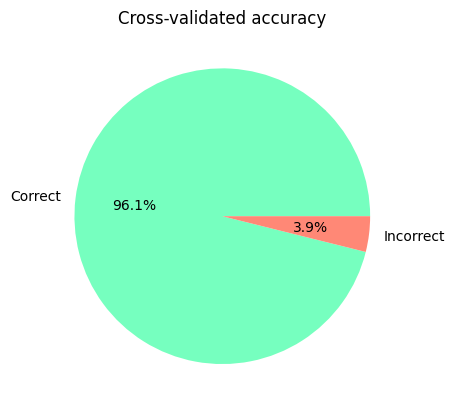

In [18]:
fig, ax = plt.subplots()
ax.pie([exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0],
        1 - exploration_results.select(pl.mean("correct_prediction")).to_series().to_list()[0]],
       labels=["Correct", "Incorrect"],
       autopct="%1.1f%%",
       colors=["#76ffbf", "#ff8876"])
plt.title("Cross-validated accuracy")
plt.show()

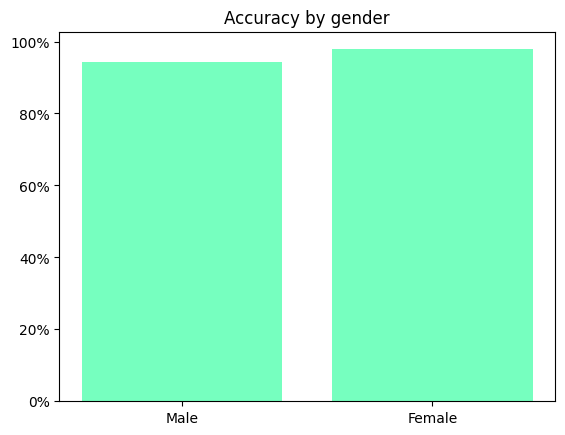

In [19]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}

accuracy_by_gender = (exploration_results.select(["label", "correct_prediction"])
.group_by("label")
.mean()
.with_columns(
    pl.col("label").replace(idx_to_class)
))

fig, ax = plt.subplots()
ax.bar(list(zip(*accuracy_by_gender.rows()))[0], list(zip(*accuracy_by_gender.rows()))[1], color="#76ffbf")
plt.title("Accuracy by gender")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))

plt.show()

# Unlabeled images

In [20]:
unlabeled_dataset = ImageFolder(os.path.join(data_dir, 'Unlabeled'), transform=tensor_transform)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=1, shuffle=False)

unlabeled_predictions = predict_model_resnet(unlabeled_loader)
unlabeled_predictions.drop(["label", "correct_prediction"])
unlabeled_predictions = add_occupation(unlabeled_predictions)

Highest-confidence images


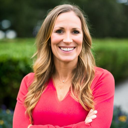

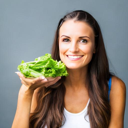

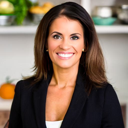

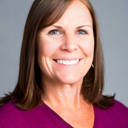

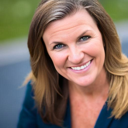

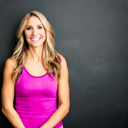

In [119]:
unlabeled_predictions.sort("confidence", descending=True).head(6).to_series(0)
print("Highest-confidence images")
for img_path in unlabeled_predictions.sort("confidence", descending=True).head(6).to_series(0):
    img = PIL.Image.open(img_path)
    display(PIL.Image.open(img_path).resize((128, 128)))

In [139]:
unlabeled_prediction_summary = (unlabeled_predictions
                                .select(["occupation", "prediction"])
                                .group_by("occupation")
                                .agg(
    pl.mean("prediction"),
    pl.count().alias("n")
)
                                .sort("prediction", descending=True)
                                .filter(pl.col("n") > 99))

unlabeled_prediction_summary

occupation,prediction,n
str,f64,u32
"""doctor""",0.951395,2222
"""chiropractor""",0.921951,205
"""dentist""",0.844622,251
"""paramedic""",0.835655,359
"""psychologist""",0.764151,318
"""pharmacist""",0.737109,2172
"""veterinarian""",0.466125,369
"""social""",0.430769,325
"""phlebotomist""",0.146119,219


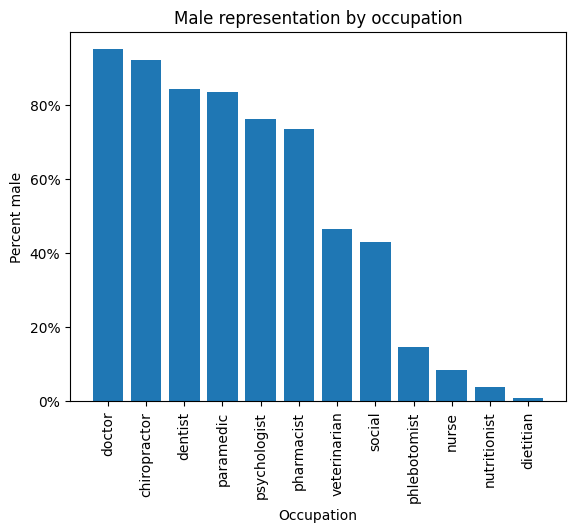

In [153]:
fig, ax = plt.subplots()
ax.bar(unlabeled_prediction_summary["occupation"].to_list(),
       unlabeled_prediction_summary["prediction"].to_list())

ax.set_title("Male representation by occupation")
ax.set_ylabel("Percent male")
ax.set_xlabel("Occupation")
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
plt.xticks(unlabeled_prediction_summary["occupation"].to_list(), rotation='vertical')

plt.show()

In [112]:
unlabeled_predictions.sort("confidence").head(25).select("file_path").write_csv("unlabeled_path_test.csv")

In [113]:
label_images("unlabeled_path_test.csv", "labels.csv")

Key pressed: f
Key pressed: m
Key pressed: d
Key pressed: f
Key pressed: d
Key pressed: f
Key pressed: f
Key pressed: f
Key pressed: f
Key pressed: m
Key pressed: f
Key pressed: d
Key pressed: d
Key pressed: f
Key pressed: f
Key pressed: d
Key pressed: d
Key pressed: f
Key pressed: m
Key pressed: d
Key pressed: d
Key pressed: m
Key pressed: f
Key pressed: f
Key pressed: f


# Manual review
* Classify and move low-confidence and incorrect training images within training directory
* Classify and move low-confidence and incorrect holdout images within holdout directory
* Report holdout classification accuracy by occupation and gender
* Classify low-confidence unlabeled images and copy them to the training directory
* Make sure training classes remain balanced
* Classify a random sample of holdout images to assess model accuracy and inter-rater bias